In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from cv_utils import *
from loss_utils import get_loss

In [2]:
def invert_image(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a threshold to create a binary mask
    _, mask = cv2.threshold(gray, 251, 255, cv2.THRESH_BINARY)
    
    # Invert the binary mask
    mask = cv2.bitwise_not(mask)
    inverted_image = cv2.bitwise_and(image, image, mask=mask)
    return inverted_image

((1280, 1920, 3), (1280, 1920, 3))

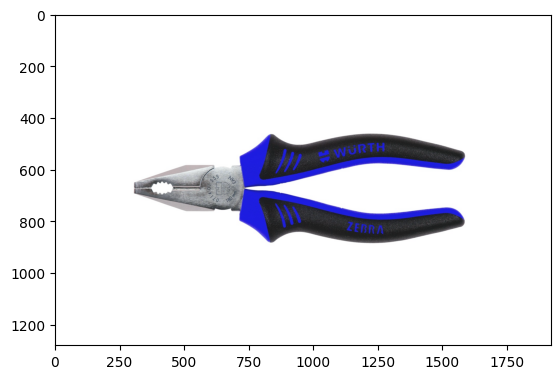

In [20]:
#image_path = r"C:\Users\wn00217454\computer_vision\thesis\data\datasets\labelled_dataset\6020021201\6020021201.webp"
image_path = r"C:\Users\wn00217454\computer_vision\thesis\data\datasets\dataA\6020021201_110.jpg"
image_path = r"C:\Users\wn00217454\computer_vision\thesis\data\datasets\dataA\6020021201_0.jpg"
#image_path = r"C:\Users\wn00217454\computer_vision\thesis\data\datasets\dataA\6020021201_240.jpg"
#image_path = r"C:\Users\wn00217454\computer_vision\thesis\data\datasets\dataA\6020021201_220.jpg"
#image_path = r"C:\Users\wn00217454\computer_vision\thesis\data\datasets\dataA\6020021201_310.jpg"
#image_path = r"C:\Users\wn00217454\computer_vision\thesis\data\datasets\google_dataset\img08.jpg"
image_path = r"C:\\Users\\wn00217454\\computer_vision\\thesis\\data\\datasets\\google_dataset\141874.jpg"

#template = cv2.resize(cv2.imread(image_path, 0), (0, 0), fx=0.8, fy=0.8)
img= cv2.imread(image_path)
image = cv2.imread(image_path)
img= invert_image(img)
img= remove_noise(img)
#template = cv2.resize(template, (224, 224))
h, w, c = img.shape
plt.imshow(image)
img.shape, img.shape

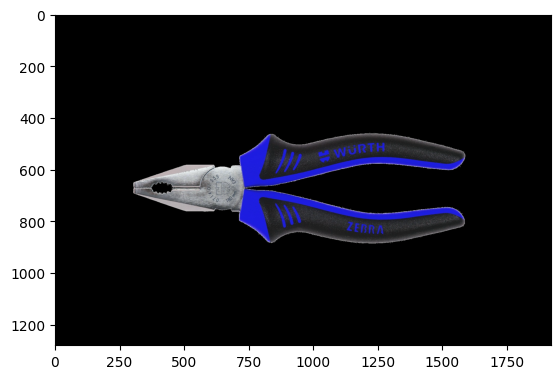

In [22]:
def invert_image_green(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a threshold to create a binary mask
    _, mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)
    
    # Invert the binary mask
    mask = cv2.bitwise_not(mask)
    inverted_image = cv2.bitwise_and(image, image, mask=mask)
    return inverted_image

green_img = invert_image_green(img)
plt.imshow(green_img)

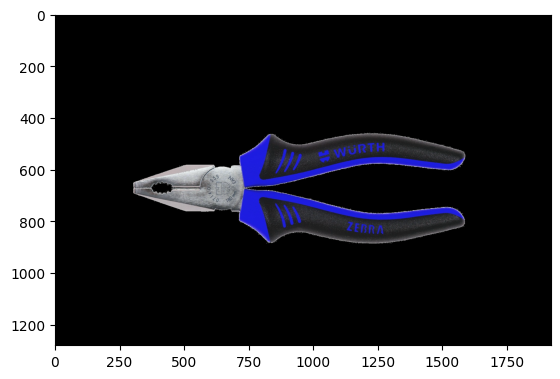

In [4]:
plt.imshow(img)

In [10]:
def remove_border_noise(mask, n):
    # Convert the mask to binary
    mask_binary = np.where(mask > 0, 1, 0).astype(np.uint8)

    # Create a structuring element for erosion
    kernel = np.ones((n, n), np.uint8)

    # Perform morphological erosion
    mask_eroded = cv2.erode(mask_binary, kernel, iterations=1)

    # Convert the eroded mask back to the original data type
    mask_eroded = np.where(mask_eroded > 0, 255, 0).astype(np.uint8)

    return mask_eroded

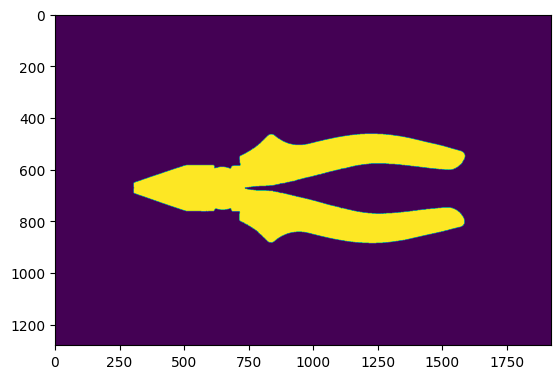

In [11]:
mask_eroded = remove_border_noise(mask, 3)
plt.imshow(mask_eroded)

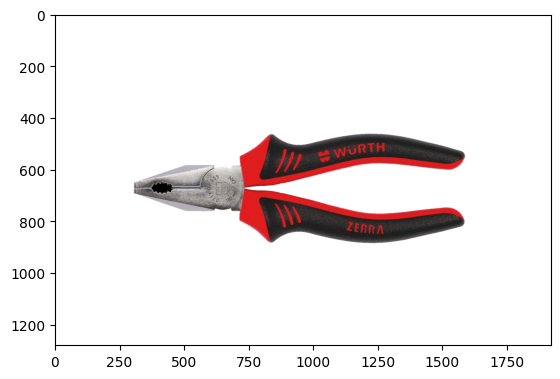

In [19]:
def white_bg(image, mask_bool):
    # Convert True/False mask to 0/255 mask
    mask_255 = mask_bool.astype(np.uint8) * 255

    # Create a white background image
    background = np.ones_like(image) * 255

    # Apply inverse mask to the original image
    background_only = cv2.bitwise_and(image, image, mask=~mask_255)

    # Apply mask to the white background
    object_only = cv2.bitwise_and(background, background, mask=mask_255)

    # Combine the object and background
    result = cv2.add(object_only, background_only)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result

wbg = white_bg(img, ~mask_eroded)
bg = invert_image(wbg)
plt.imshow()

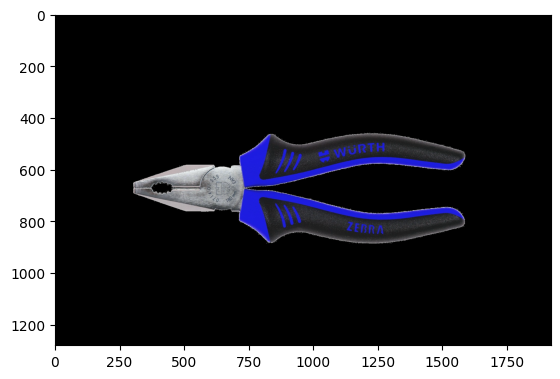

In [18]:
plt.imshow(img)

In [5]:
def find_object_mask(image):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding to convert image to binary
    _, binary_image = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    max_contour = max(contours, key=cv2.contourArea)
    
    # Create an empty mask
    mask = np.zeros_like(gray_image)
    
    # Draw contours on the mask
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

    rotated_rect = cv2.minAreaRect(max_contour)
    angle = rotated_rect[-1]
    
    return (angle - 90), mask

In [6]:
angle, mask = find_object_mask(img)
angle, mask.shape

(-89.7753118276596, (1280, 1920))

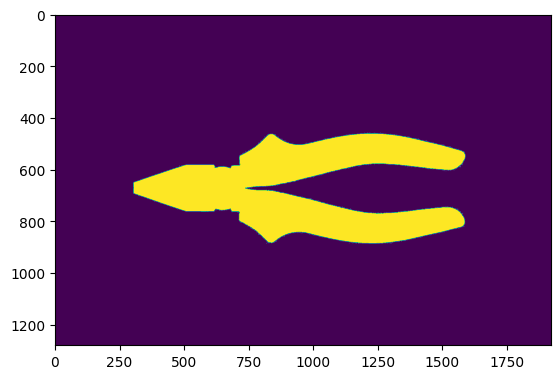

In [7]:
plt.imshow(mask)

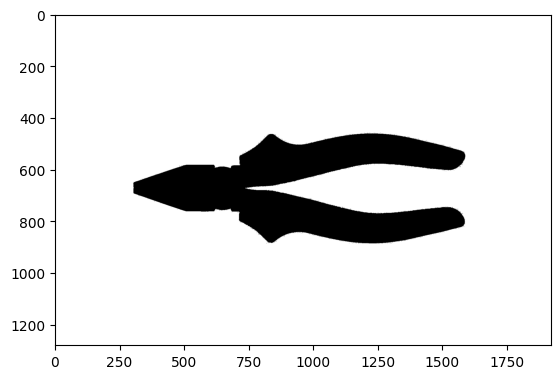

In [8]:
def create_object_mask3c(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Threshold the grayscale image to obtain a binary image
    ret, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a mask with the same dimensions as the input image
    mask = np.zeros_like(image)
    
    # Draw filled contours on the mask
    cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)
    
    # Invert the mask
    mask = cv2.bitwise_not(mask)
    
    return mask

mask3c = create_object_mask3c(img)
plt.imshow(mask3c)

In [9]:
cv2.imwrite("141874_mask.png", mask3c)

True

In [52]:
np.unique(mask)

array([  0, 255], dtype=uint8)

In [112]:
def add_shadow(masked_image, shadow_intensity=0.1):
    # Create a shadow color (e.g., dark gray)
    shadow_color = np.array([50, 50, 50], dtype=np.uint8)
    
    # Resize shadow color to match the shape of the masked image
    shadow_color_resized = np.full_like(masked_image, shadow_color[0])
    
    # Blend the original image with the shadow color using the shadow intensity
    shadowed_image = cv2.addWeighted(masked_image, 1, 
                                      shadow_color_resized, 
                                      shadow_intensity, 0)
    
    return shadowed_image.astype(np.uint8)

In [113]:
shadow_mask = add_shadow(mask)

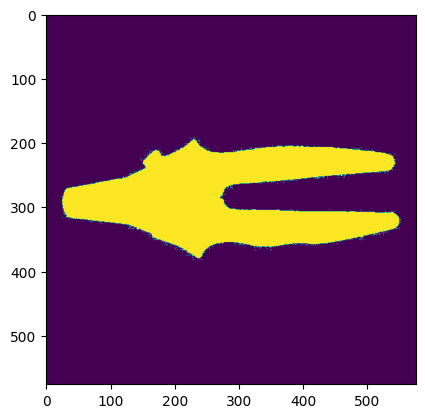

In [114]:
plt.imshow(shadow_mask)

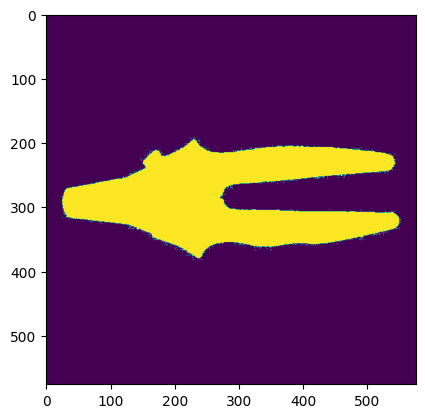

In [115]:
plt.imshow(mask)